# KLD trajectories

Much of the analysis we've done so far has treated the "anticipation/resonance" scores of volumes as indivisible units.

But actually these scores are averages, based on a series of novelty or transience scores across a longer timespan. Ultimately those scores involve KLD comparisons between individual volumes, and we can trace them down to that level if we like. But let's start by going one level down to yearly averages. I'll refer to a series of yearly averages for a volume (±50 yrs) as a "trajectory."

The problem in doing this is that the trajectories for all volumes end up quite voluminous -- possibly a little too much for a github repo. But let's see if we can reduce it to a manageable subset.

We want

    1. All the trajectories for vols we need to test hypotheses.

    2. A random sample of vols to use as a background contrast set. Let's say, ideally, ten US and ten non-US vols for each year in the timeline.

Let's start by reading the metadata we need to identify these sets.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import glob, math, random
from scipy.stats import pearsonr, zscore
from statistics import mean, stdev
from math import sqrt
from collections import Counter

#### metadata for hypotheses

In [12]:
hypothesis_meta = pd.read_csv('../supplement2/hypothesis_wnationality_meta.tsv', sep = '\t', index_col = 'docid')

#### selected kld data (more is available)

In [4]:
contrast_data = pd.read_csv('../supp2results/contrastklds.tsv', sep = '\t', index_col = 'docid')
hypothesis_data = pd.read_csv('../supp2results/hypothesisklds.tsv', sep = '\t', index_col = 'docid')

### Some general functions to use later

Okay, first we need a function that

1. selects volumes matching a bunch of hypotheses (like e.g. 'norton' or 'heath') and
2. selects "contrast" volumes that match the date and nationality of the hypothesis set

That follows, and I use it to select "bestsellers" and "notbestsellers."

In [13]:
def construct_two_sets(hypmeta, hypothesis_list, contrast_data):
    ''' This function assumes that the index on both
    hypmeta and meta has been set to 'docid.'
    '''
    
    vols_in_cat = []
    for cat in hypothesis_list:
        vols_in_cat.extend(hypmeta.index[hypmeta[cat] == True].tolist())
    
    # It's possible to get duplicates that way, so:
    
    vols_in_cat = list(set(vols_in_cat))
    
    nation_dates_of_cat = []
    for v in vols_in_cat:
        nation_dates_of_cat.append((int(hypmeta.loc[v, 'latestcomp']), hypmeta.loc[v, 'inferrednation']))
    
    contrast_cat = []
    for date, nation in nation_dates_of_cat:
        if nation == 'us' or nation == 'guess: us':
            candidates = contrast_data.index[(contrast_data.nationality == 'us') & 
                                             (contrast_data.latestcomp == date)].tolist()
            random.shuffle(candidates)
            for c in candidates:
                if c not in contrast_cat:
                    contrast_cat.append(c)
                    break
        else:
            candidates = contrast_data.index[(contrast_data.nationality != 'us') & 
                                             (contrast_data.latestcomp == date)].tolist()
            random.shuffle(candidates)
            for c in candidates:
                if c not in contrast_cat:
                    contrast_cat.append(c)
                    break
            
    
    if len(vols_in_cat) != len(contrast_cat):
        print('We were unable to match everything. Caveat emptor.')
    
    return vols_in_cat, contrast_cat, nation_dates_of_cat
    
    
bestsellers, notbestsellers, nationdates = construct_two_sets(hypothesis_meta, ['bestseller'], contrast_data)

We were unable to match everything. Caveat emptor.


In [14]:
print('The number missing is not huge: ')
print('bestsellers: ', len(bestsellers))
print('not bestsellers: ', len(notbestsellers))

The number missing is not huge: 
bestsellers:  813
not bestsellers:  807


### visualization strategy

It's easy enough to sum the KLDs for all the volumes in our hypothesis and contrast sets. That will give us, basically, two sine-shaped curves.

But what we really want to know is,

    At what point(s) in the timeline does the difference between our "hypothesis" set and our "contrast" set contribute most to the greater resonance of the hypothesis set.
    
That's a rather tricky question. Intuitively, I think the way to answer it is to convert both curves to z scores and subtract one from the other.

Providing a statistical argument to justify my intuition ... will take a while. But basically, resonance is a self-comparison of points on curve a to the rest of the curve. And the strategy I'm using will tell us where curve a) is higher *relative to itself* than b) is relative to *itself.*

In [32]:
def display_fraction(hypothesis_docs, contrast_docs, hypothesis_data, contrast_data, fraction):
    summed_hyp = np.zeros(101)
    summed_con = np.zeros(101)
    
    all_hyp = []
    all_con = []
    for doc in hypothesis_docs:
        df = hypothesis_data.loc[doc, : ]
        vector = df.loc[df.fraction == fraction, '-50' : '50']
        summed_hyp = summed_hyp + vector
        all_hyp.append(np.array(vector))

    for doc in contrast_docs:
        df = contrast_data.loc[doc, : ]
        vector = df.loc[df.fraction == fraction, '-50' : '50']
        summed_con = summed_con + vector
        all_con.append(np.array(vector))
        
    all_con = np.array(all_con)
    all_hyp = np.array(all_hyp)
    
    conmean = np.nanmean(all_con, axis = 0)[0]
    overallcmean = np.mean(conmean)
    overallcstd = np.std(conmean)
    conzscore = (conmean - overallcmean) / overallcstd
    
    hypmean = np.nanmean(all_hyp, axis = 0)[0]
    overallhmean = np.mean(hypmean)
    overallhstd = np.std(hypmean)
    hypzscore = (hypmean - overallhmean) / overallhstd

    normdiff = hypzscore - conzscore
    
    # the multiplier below is necessary because resonance is
    # novelty - transience
    # so transience (future) should be negative
    # that will give us a normdiff that is positive wherever
    # the difference of curves is contributing to the superior
    # resonance of our hypothesis set
    
    multiplier = (50 * [1]) + [0] + (50 * [-1])
    normdiff = normdiff * multiplier
    
    return hypmean, conmean, normdiff

### bestsellers, resonance at 100% fraction

Let's start with fraction 1.0 (using everying).

In [33]:
hypmean, conmean, hypnorm = display_fraction(bestsellers, notbestsellers, hypothesis_data, contrast_data, 1.0)

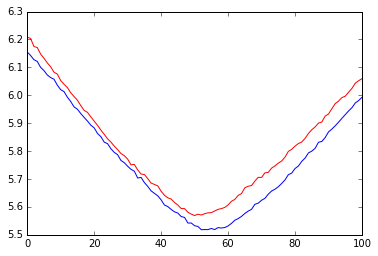

In [34]:
plt.plot([x for x in range(101)], hypmean, c = 'b')
plt.plot([x for x in range(101)], conmean, c = 'r')
plt.show()

I think one can't infer too much from the absolute position of those curves. Just looking at that, you might think that the big difference is that contrast volumes generally have higher KLD (both novelty and resonance) than the blue (bestseller) volumes.

But really I think the significance we're after is that the blue curve is, so to speak, forward-shifted relative to the red curve. The difference of z scores better illustrates where that makes a difference.

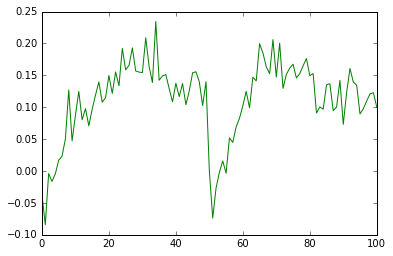

In [35]:
plt.plot([x for x in range(101)], hypnorm, c = 'g')
plt.show()


The effect on resonance/anticipation seems to peak far in the future. It's also big 20-40 years in the past. It doesn't make much difference near the midpoint of this 101 year timeline -- which is what we would expect, if we're really measuring a forward skew in similarities.

### Bestsellers at the 5% fraction

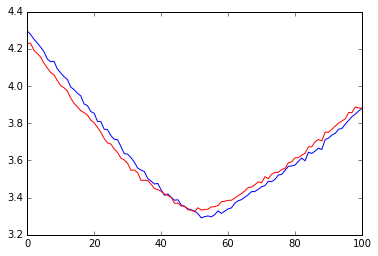

In [36]:
hypmean, conmean, hypnorm = display_fraction(bestsellers, notbestsellers, hypothesis_data, contrast_data, 0.05)
plt.plot([x for x in range(101)], hypmean, c = 'b')
plt.plot([x for x in range(101)], conmean, c = 'r')
plt.show()

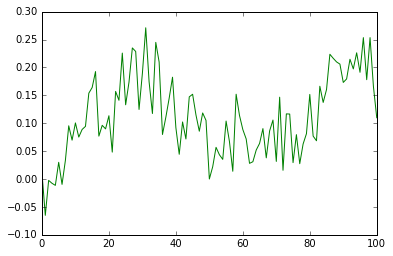

In [37]:
plt.plot([x for x in range(101)], hypnorm, c = 'g')

Broadly similar pattern. Expanding the temporal window might not help here, because the effect actually gets negative far in the past.

### The canon, at 100% fraction

We're going to include mostdiscussed in the canon for now.

In [21]:
canon, notcanon, nationdates = construct_two_sets(hypothesis_meta, ['mostdiscussed', 'norton', 'heath'], contrast_data)

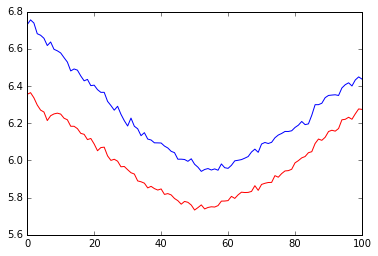

In [22]:
hypmean, conmean, hypnorm = display_fraction(canon, notcanon, hypothesis_data, contrast_data, 1.0)
plt.plot([x for x in range(101)], hypmean, c = 'b')
plt.plot([x for x in range(101)], conmean, c = 'r')
plt.show()

Whoa. That's totally different. Now the blue (canonical) volumes have higher KLD (both novelty and transience) than the contrast set.

This makes some sense, since we expect bestsellers to be relatively conventional and canonical volumes to be selected as in some way exceptional.

But again, where anticipation/resonance is concerned, we're not interested in the absolute position of the curves but in the slight forward skew of the blue one. For that, we need to compare zscores at each position.

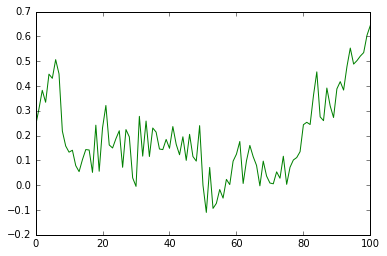

In [23]:
plt.plot([x for x in range(101)], hypnorm, c = 'g')

Loosely similar pattern: divergences are strong in the far future. We're not seeing the same clear "hump" in the past, though.

### The canon, at 5% fraction

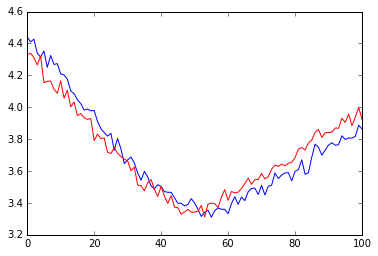

In [24]:
hypmean, conmean, hypnorm = display_fraction(canon, notcanon, hypothesis_data, contrast_data, 0.05)
plt.plot([x for x in range(101)], hypmean, c = 'b')
plt.plot([x for x in range(101)], conmean, c = 'r')
plt.show()

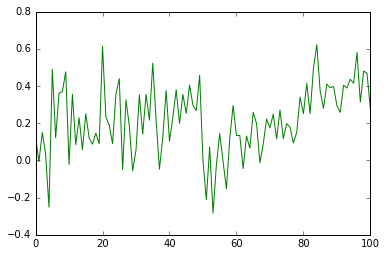

In [25]:
plt.plot([x for x in range(101)], hypnorm, c = 'g')

A lot of noise there, to be frank. Hard to describe the pattern.

### Reviewed and not-reviewed volumes

I'm going to need to do this slightly differently, because I don't need a random contrast set. There's a contrast set already in hypothesis data, because I manually selected not-reviewed volumes.

In [26]:
reviewed, genuinerandom, nationdates = construct_two_sets(hypothesis_meta, ['reviewed'], contrast_data)

We were unable to match everything. Caveat emptor.


In [27]:
notreviewed, anotherrandom, nationdates = construct_two_sets(hypothesis_meta, ['contrast4reviewed'], contrast_data)

We were unable to match everything. Caveat emptor.


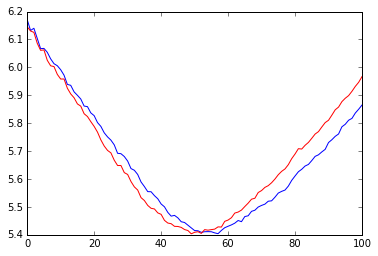

In [28]:
def display_fraction4reviewed(hypothesis_docs, contrast_docs, hypothesis_data, fraction):
    summed_hyp = np.zeros(101)
    summed_con = np.zeros(101)
    
    all_hyp = []
    all_con = []
    for doc in hypothesis_docs:
        df = hypothesis_data.loc[doc, : ]
        vector = df.loc[df.fraction == fraction, '-50' : '50']
        summed_hyp = summed_hyp + vector
        all_hyp.append(np.array(vector))

    for doc in contrast_docs:
        df = hypothesis_data.loc[doc, : ]
        vector = df.loc[df.fraction == fraction, '-50' : '50']
        summed_con = summed_con + vector
        all_con.append(np.array(vector))
        
    all_con = np.array(all_con)
    all_hyp = np.array(all_hyp)
    
    conmean = np.nanmean(all_con, axis = 0)[0]
    overallcmean = np.mean(conmean)
    overallcstd = np.std(conmean)
    conzscore = (conmean - overallcmean) / overallcstd
    
    hypmean = np.nanmean(all_hyp, axis = 0)[0]
    overallhmean = np.mean(hypmean)
    overallhstd = np.std(hypmean)
    hypzscore = (hypmean - overallhmean) / overallhstd

    normdiff = hypzscore - conzscore
    multiplier = (50 * [1]) + [0] + (50 * [-1])
    normdiff = normdiff * multiplier
    
    return hypmean, conmean, normdiff

hypmean, conmean, hypnorm = display_fraction4reviewed(reviewed, notreviewed, hypothesis_data, 1.0)
plt.plot([x for x in range(101)], hypmean, c = 'b')
plt.plot([x for x in range(101)], conmean, c = 'r')
plt.show()

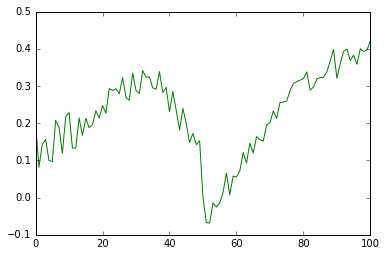

In [29]:
plt.plot([x for x in range(101)], hypnorm, c = 'g')

Okay. I'm going to say this is clearer than anything I've seen so far. The effect on resonance is strong like 15 years in the past (reviewed works are *more* different from the recent past than obscure works). But it's also strong in the far future (reviewed works get *less* different from the future as we go into the future. Peaks like 40 years out.

### Trying a genuinely random contrast set

Notice that if I use a genuinely random contrast set, I get bizarrely high novelty for the genuine random works. This makes me wonder if there's a problem with sampling or dating somewhere.

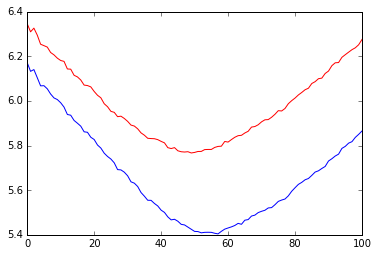

In [30]:
hypmean, conmean, hypnorm = display_fraction(reviewed, genuinerandom, hypothesis_data, contrast_data, 1.0)
plt.plot([x for x in range(101)], hypmean, c = 'b')
plt.plot([x for x in range(101)], conmean, c = 'r')

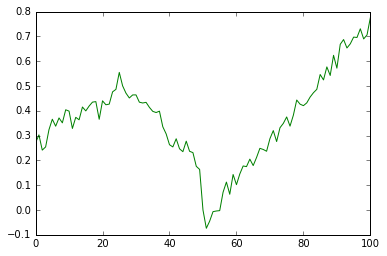

In [31]:
plt.plot([x for x in range(101)], hypnorm, c = 'g')

However, notice that the effect on **resonance** is very nearly the same. The absolute positions of the red and blue curves are much more volatile and sensitive to sampling effects than the forward skew.